In [1]:
import pandas 

df = pandas.read_csv( 'feature_sets/expression_foldx.csv', index_col=0 ) 
print df.sample( 5 ) 

        total energy  Backbone Hbond  Sidechain Hbond  Van der Waals  \
mutant                                                                 
I244N        1.59865       -0.088886        -0.853333       0.847205   
N293A        1.18221        0.066575         3.287340       1.155630   
F415N        3.27845        0.080538        -1.355230       1.464500   
L171A        1.80734       -0.172320        -0.240424       1.271170   
I244E        2.85648       -0.150997        -0.193160       0.695632   

        Electrostatics  Solvation Polar  Solvation Hydrophobic  \
mutant                                                           
I244N         0.238336        -0.216585               2.243060   
N293A         0.009513        -2.921390               0.566258   
F415N         0.317912         0.052576               2.908610   
L171A        -0.679258        -0.089974               2.255120   
I244E        -0.683821         1.336480               1.743510   

        Van der Waals clashes  e

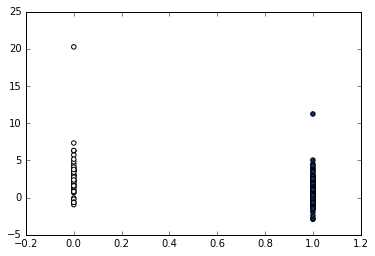

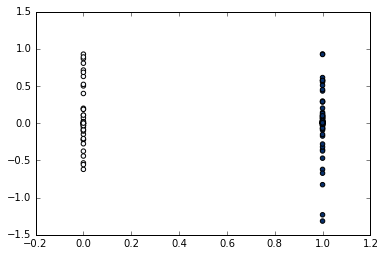

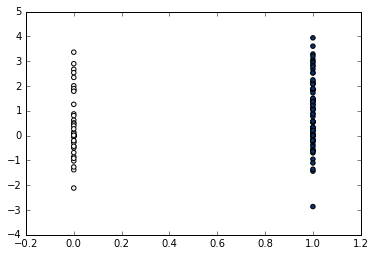

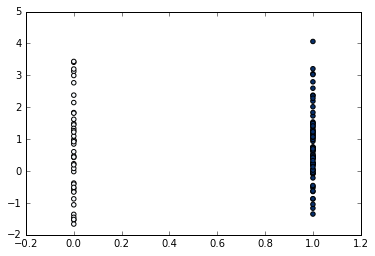

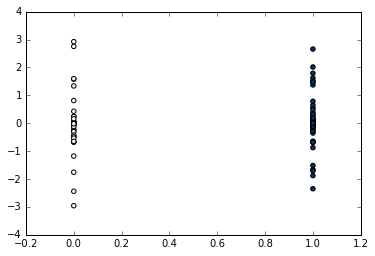

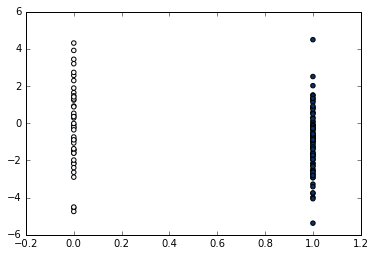

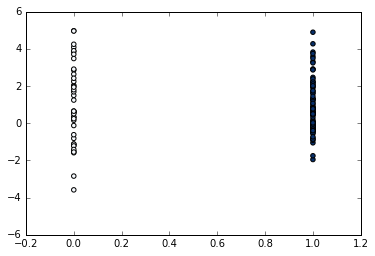

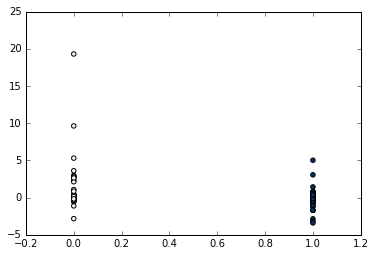

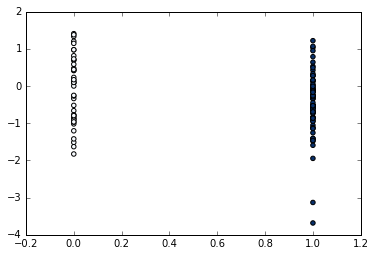

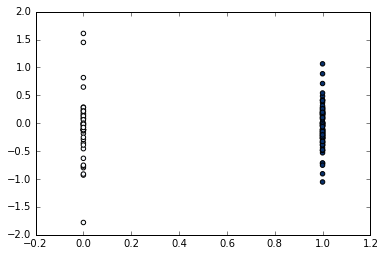

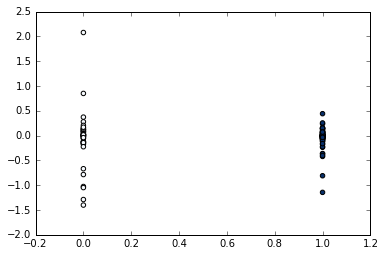

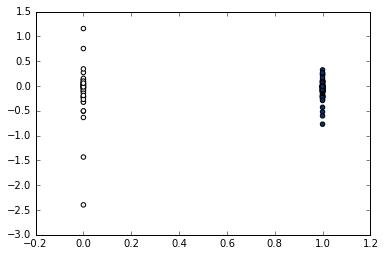

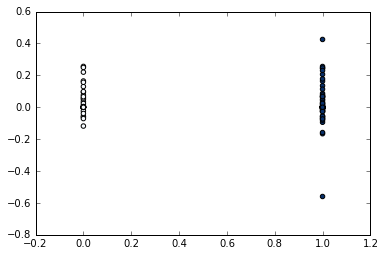

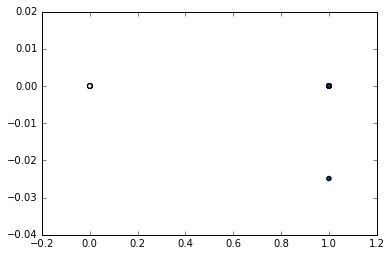

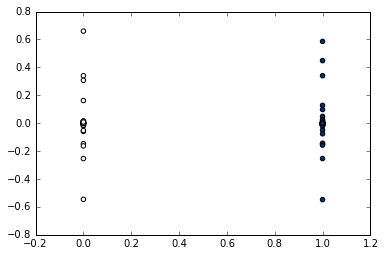

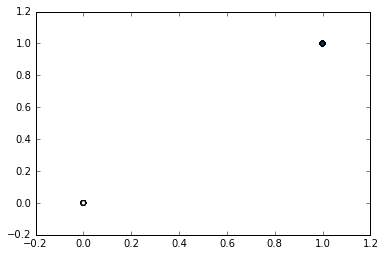

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt 

for feature in df.columns:
    plt.scatter( df.expression, df[ feature ], c=df.expression, cmap='Blues' ) 
    plt.show()

In [3]:
import pandas
import matplotlib.pyplot as plt 
from sklearn import preprocessing, cross_validation, ensemble, pipeline, svm, decomposition
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, roc_curve

In [4]:
scl = preprocessing.RobustScaler()
X = scl.fit_transform( df.ix[:,:-1] )
y = df.ix[:,-1:].as_matrix().ravel()

(array([ 43.,  85.]), array([ 0. ,  0.5,  1. ]), <a list of 2 Patch objects>)

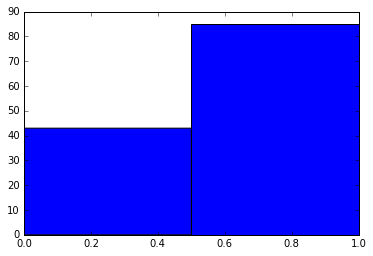

In [5]:
# unbalanced classes 
plt.hist( y, bins=2 )

In [6]:
print X.shape
print y.shape

(128, 15)
(128,)


Best parameters found on training set
{'rf__n_estimators': 10, 'rf__criterion': 'gini', 'rf__max_depth': 10, 'rf__class_weight': 'balanced_subsample', 'rf__max_features': None}
Grid scores on training set
0.719 (±0.334) for {'rf__n_estimators': 10, 'rf__criterion': 'entropy', 'rf__max_depth': 2, 'rf__class_weight': 'balanced_subsample', 'rf__max_features': 'sqrt'}
0.688 (±0.239) for {'rf__n_estimators': 10, 'rf__criterion': 'entropy', 'rf__max_depth': 2, 'rf__class_weight': 'balanced_subsample', 'rf__max_features': None}
0.688 (±0.400) for {'rf__n_estimators': 10, 'rf__criterion': 'entropy', 'rf__max_depth': 5, 'rf__class_weight': 'balanced_subsample', 'rf__max_features': 'sqrt'}
0.719 (±0.211) for {'rf__n_estimators': 10, 'rf__criterion': 'entropy', 'rf__max_depth': 5, 'rf__class_weight': 'balanced_subsample', 'rf__max_features': None}
0.719 (±0.249) for {'rf__n_estimators': 10, 'rf__criterion': 'entropy', 'rf__max_depth': 10, 'rf__class_weight': 'balanced_subsample', 'rf__max_feature

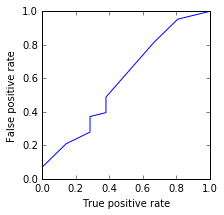

,importance
feature,
torsional clash,0.230090
total energy,0.173608
Van der Waals clashes,0.096412
Sidechain Hbond,0.091128
Backbone Hbond,0.074171
Solvation Hydrophobic,0.070846
electrostatic kon,0.068576
entropy sidechain,0.054370
energy Ionisation,0.036865


In [8]:
# random forest classifier 

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
param_grid = [
    { 
        'rf__criterion': [ 'entropy', 'gini' ], 
        'rf__n_estimators': [ 10 ], 
        'rf__max_features': [ 'sqrt', None ], 
        'rf__max_depth': [ 2, 5, 10 ], 
        'rf__class_weight': [ 'balanced_subsample' ], 
    },
]
  
pln = pipeline.Pipeline([
    ( 'rf', ensemble.RandomForestClassifier() ),
])

clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

print("Best parameters found on training set")
print(clf.best_params_)

print("Grid scores on training set")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

print("Detailed classification report")
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

y_desc = clf.best_estimator_.named_steps['rf'].predict_proba( X )
y_prob = [ x[y] for x, y in zip( y_desc, y_true ) ]

tpr, fpr, __ = roc_curve( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.show()

feat_import = clf.best_estimator_.named_steps['rf'].feature_importances_
w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
w.set_index( 'feature', inplace=True ) 
w.sort_values( by='importance', ascending=False )

In [9]:
# SVM with PCA 
param_grid = [
    { 
        'svm__kernel': [ 'rbf' ], 
        'svm__gamma': [ 1e-3, 1e-4 ],
        'svm__C': [ .1, .3, 3, 30 ],  
        'svm__class_weight': [ 'balanced' ],
        'pca__n_components': [ 2, 5, 10 ], 
        'pca__whiten': [ True ], 
    },
    {
        'svm__kernel': ['linear'], 
        'svm__C': [ .1, .3, 3, 30 ],
        'svm__class_weight': [ 'balanced' ],
        'pca__n_components': [ 2, 5, 10 ], 
    }
]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
        
    pln = pipeline.Pipeline([
        ( 'pca', decomposition.PCA() ), 
        ( 'svm', svm.SVC() ),
    ])

    clf = GridSearchCV(pln, param_grid, cv=10, scoring='%s_weighted' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")

    print(clf.best_params_)
    print 
    print("Grid scores on development set:")
    print 
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print 

    print("Detailed classification report:")
    print 
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print 
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    y_desc = clf.decision_function(X_test) 
    tpr, fpr, __ = roc_curve( y_true, y_desc ) 
    plt.figure( figsize=( 3,3 ) ) 
    plt.plot( tpr, fpr ) 
    plt.show()

TypeError: Singleton array 0 cannot be considered a valid collection.